# Sandbox

Sandbox script to work on functions while other functions are running in the background

In [57]:
%reset -f

In [58]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
%reload_ext autoreload
%autoreload 2

In [114]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels, CreateScenarioDictionary, ClassifyHistModelsLite

### Working on matching up historical and scenario models when there isn't a one:one

In [437]:
# inputting from a csv file
directory = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(directory)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# selecting the models
#models = ['MIROC6', 'CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR']
models = ['MIROC-ES2L']

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             ((inputScenario['grid_label'] == 'gn') |
                             (inputScenario['grid_label'] == 'gr'))
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(models) &
                     (inputHist['variable_id'] == 'ts') & 
                     ((inputHist['grid_label'] == 'gn') |
                     (inputHist['grid_label'] == 'gr'))
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

In [438]:
histModelsTest = ClassifyHistModelsLite(modelListHist)

## Working out the jump between Dec and Jan for the concatenation

In [399]:
# from the concat jump function

# want to add in a function to also have it be compared to Dec / Jan jumps for the rest of the period
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_2024-03-14'
os.chdir(gradientsDir)

# list of models that we are interested in for this
models = ['IPSL-CM6A-LR']
modelName = models[0] #CHANGE THIS
modelNamesGrad = []

# get a list of all of the files in the directory (getting rid of the python checkpoints one)
gradientFiles = os.listdir(gradientsDir)
gradientFiles = [f for f in gradientFiles if '.nc' in f and modelName in f]
concatJumpFullHist = []
concatJumpJanDec = []

histStart = '1850-01-16T12:00:00.000000000'
histEnd = '2014-12-16T12:00:00.000000000'
scenStart = '2015-01-16T12:00:00.000000000'

for file in gradientFiles:      
    # getting the modelName
    charIndex = file.index('.')
    modelNamesGrad.append(file[:charIndex])
    
    # calculating the jump relative to std
    modelGradient = xr.open_dataset(file)
    jump = (modelGradient.sel(time = histEnd) - modelGradient.sel(time = scenStart)).ts.item()

    # calculating standard deviation of historical period
    stdHist = modelGradient.sel(time = slice(histStart, histEnd)).std(dim = 'time').ts.item()
    meanHist = modelGradient.sel(time = slice(histStart, histEnd)).mean(dim = 'time').ts.item()
    
    concatJumpFullHist.append((jump - meanHist)/stdHist)
    
    # calculating difference between December and January for historical period
    # first selecting the right period so that we have Jan of 1851 and December of 1850 at the start and Jan 2015 and Dec 2014 at the end
    janStart = '1851-01-16T12:00:00.000000000'
    janEnd = '2015-02-16T12:00:00.000000000'
    decStart = '1850-01-16T12:00:00.000000000'
    decEnd = '2015-01-16T12:00:00.000000000'

    janValues = modelGradient.sel(time = slice(janStart, janEnd)).where(modelGradient['month'] == 1, drop = True).ts.values
    decValues = modelGradient.sel(time = slice(decStart, decEnd)).where(modelGradient['month'] == 12, drop = True).ts.values
    janDecDiff = janValues - decValues
    janDecDiffMean = np.mean(janDecDiff)
    janDecDiffSTD = np.std(janDecDiff)
    
    concatJumpJanDec.append((jump - janDecDiffMean)/janDecDiffSTD)

## Combining match and jump data

In [400]:
matchDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Model_Statistics'
os.chdir(matchDir)

fileName = 'Match_data_2024-03-14.csv'
matchData = pd.read_csv(fileName, index_col = 0)

# creating a new column with the model name (note that these are all before the first _)
models = []
for modelName in list(matchData.index):
    charIndex = modelName.index('_')
    models.append(modelName[:charIndex])
    
matchData['Model'] = models
matchData.reindex(columns = ['Model', 'ScenModel', 'Assignment']);

In [401]:
# now have to go into the match data and get the assignment based on the model name from the gradients
assignmentsGrad = []

for modelNameGrad in modelNamesGrad:
    if matchData['Assignment'].loc[modelNameGrad] == 'Random':
        assignmentsGrad.append('Red')
    else:
        assignmentsGrad.append('Blue')

In [474]:
# adding in the jump information
# first get a list of jump information corresponding to the histModel indices
jumpMatchHist = np.zeros(len(matchData.index))
jumpMatchJanDec = np.zeros(len(matchData.index))

for i, histModelMatch in enumerate(matchData.index):
    if histModelMatch in modelNamesGrad:
        jumpMatchHist[i] = concatJumpFullHist[modelNamesGrad.index(histModelMatch)]
        jumpMatchJanDec[i] = concatJumpJanDec[modelNamesGrad.index(histModelMatch)]
    else:
        jumpMatchHist[i] = np.nan
        jumpMatchJanDec[i] = np.nan

149

## Plotting

/tmp/ipykernel_6280/2737258716.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(modelNamesGrad, rotation = 90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


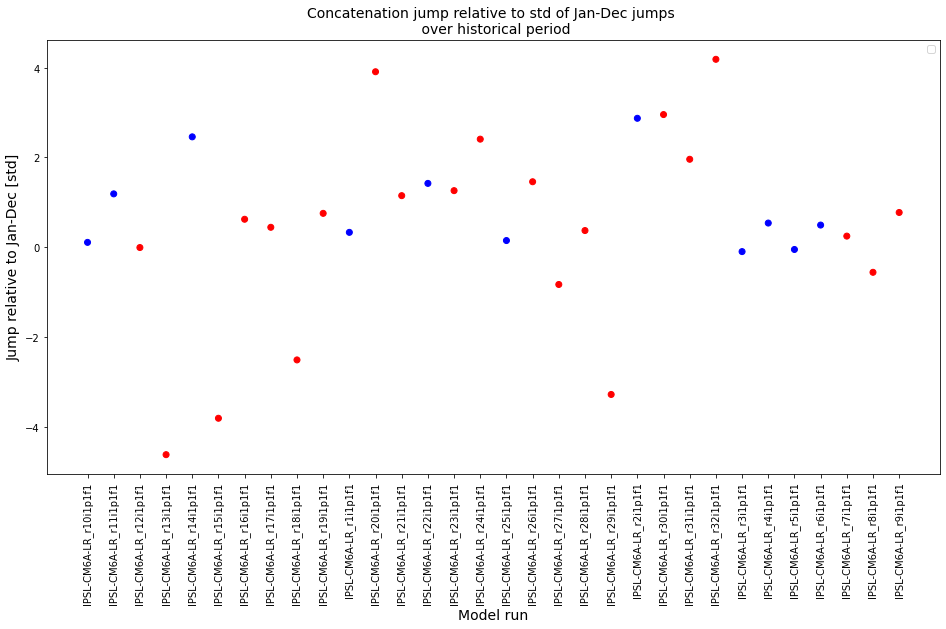

In [402]:
fig, ax = plt.subplots(figsize = (16,8))
plot = plt.scatter(modelNamesGrad, concatJumpJanDec, c = assignmentsGrad)
ax.set_title('Concatenation jump relative to std of Jan-Dec jumps \n over historical period', fontsize = 14)
ax.set_xlabel('Model run', fontsize = 14)
ax.set_ylabel('Jump relative to Jan-Dec [std]', fontsize = 14)
ax.set_xticklabels(modelNamesGrad, rotation = 90)
plt.legend()

plt.show()

/tmp/ipykernel_6280/353313331.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(modelNamesGrad, rotation = 90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


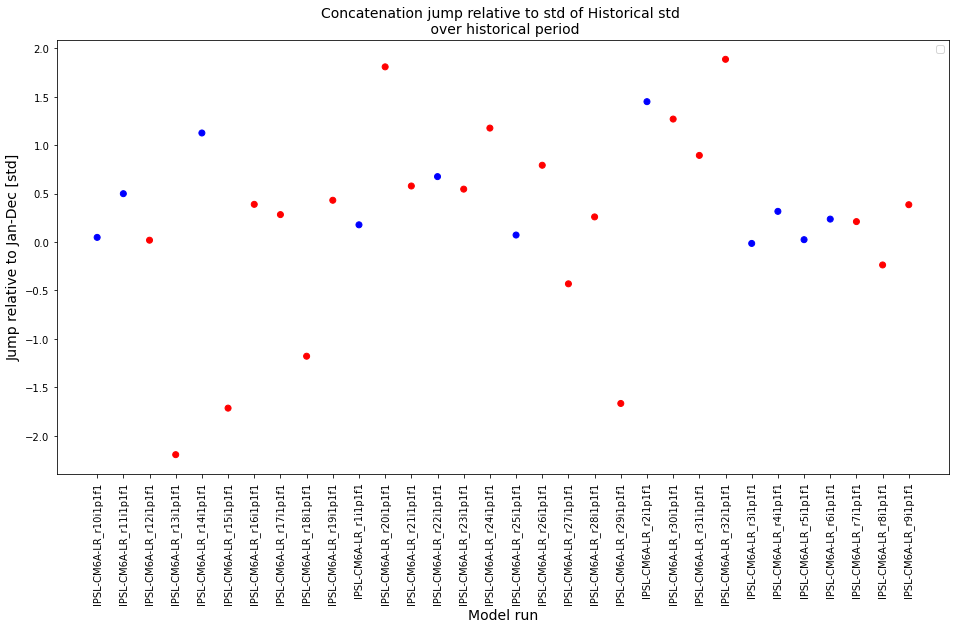

In [403]:
fig, ax = plt.subplots(figsize = (16,8))
plot = plt.scatter(modelNamesGrad, concatJumpFullHist, c = assignmentsGrad)
ax.set_title('Concatenation jump relative to std of Historical std \n over historical period', fontsize = 14)
ax.set_xlabel('Model run', fontsize = 14)
ax.set_ylabel('Jump relative to Jan-Dec [std]', fontsize = 14)
ax.set_xticklabels(modelNamesGrad, rotation = 90)
plt.legend()

plt.show()

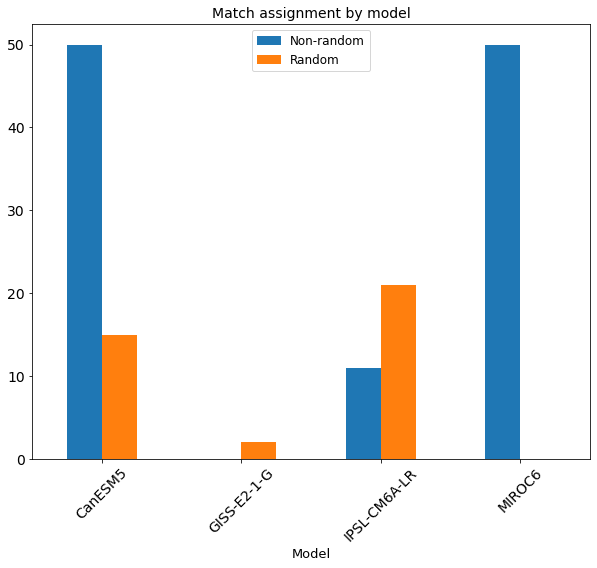

In [404]:
fig, ax = plt.subplots(figsize = (10,8))
plot = matchData.pivot_table(index = 'Model', columns = 'Assignment', aggfunc = 'count', fill_value = 0).plot(kind = 'bar', ax = ax, fontsize = 14)
plot.set_title('Match assignment by model', fontsize = 14)
plot.legend(['Non-random', 'Random'], fontsize = 12)
plot.set_xlabel('Model', fontsize = 13)
plot.set_xticklabels(ax.get_xticklabels(minor = False), rotation = 45)
plt.show()

In [440]:
modelListScenario

['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp245/r10i1p1f2/Amon/ts/gn/v20201222/ts_Amon_MIROC-ES2L_ssp245_r10i1p1f2_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp245/r11i1p1f2/Amon/ts/gn/v20201222/ts_Amon_MIROC-ES2L_ssp245_r11i1p1f2_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp245/r12i1p1f2/Amon/ts/gn/v20201222/ts_Amon_MIROC-ES2L_ssp245_r12i1p1f2_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp245/r13i1p1f2/Amon/ts/gn/v20201222/ts_Amon_MIROC-ES2L_ssp245_r13i1p1f2_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp245/r14i1p1f2/Amon/ts/gn/v20201222/ts_Amon_MIROC-ES2L_ssp245_r14i1p1f2_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp245/r15i1p1f2/Amon/ts/gn/v20201222/ts